In [334]:
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'torch version : {torch.__version__}')
print(f'device : {device}')

torch version : 2.7.1+cpu
device : cpu


In [3]:
# Download data : MNIST

training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

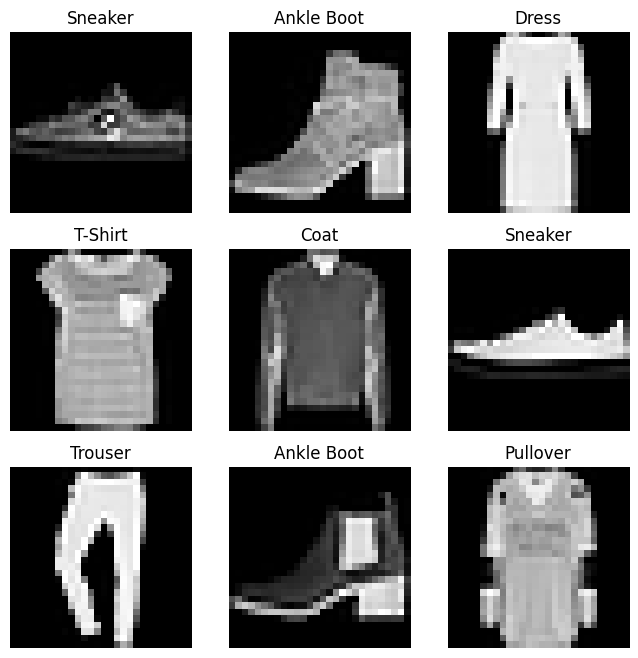

In [20]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows +1):
    sample_idx =  torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [21]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [296]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(nn.Linear(28*28, 512),
                                      nn.ReLU(),
                                      nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Linear(256, 10)
                                     )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits

In [303]:
model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [244]:
learning_rate = 1e-3
batch_size = 64
epochs = 50

In [304]:
loss_fn = nn.CrossEntropyLoss()

In [305]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [306]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):0.1f}%, Avg loss: {test_loss:>8f} \n')
        
    

In [307]:
res = []
for t in range(epochs):
    print(f'Epoch {t+1}\n------------------------------')
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    res.append([t, loss])
print('Done!')

Epoch 1
------------------------------
loss: 2.306836  [   64/60000]
loss: 2.288058  [ 6464/60000]
loss: 2.270111  [12864/60000]
loss: 2.259811  [19264/60000]
loss: 2.241662  [25664/60000]
loss: 2.238734  [32064/60000]
loss: 2.233062  [38464/60000]
loss: 2.193986  [44864/60000]
loss: 2.185211  [51264/60000]
loss: 2.170267  [57664/60000]
Test Error: 
 Accuracy: 49.6%, Avg loss: 2.161107 

Epoch 2
------------------------------
loss: 2.144437  [   64/60000]
loss: 2.141294  [ 6464/60000]
loss: 2.128024  [12864/60000]
loss: 2.107304  [19264/60000]
loss: 2.072066  [25664/60000]
loss: 2.020514  [32064/60000]
loss: 2.024482  [38464/60000]
loss: 1.968740  [44864/60000]
loss: 1.954954  [51264/60000]
loss: 1.932206  [57664/60000]
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.898703 

Epoch 3
------------------------------
loss: 1.954075  [   64/60000]
loss: 1.886864  [ 6464/60000]
loss: 1.795458  [12864/60000]
loss: 1.786430  [19264/60000]
loss: 1.804452  [25664/60000]
loss: 1.700293  [32064/60000]

Text(0, 0.5, 'loss')

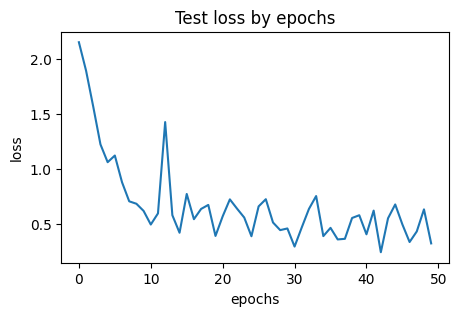

In [332]:
plt.figure(figsize=(5,3))
plt.plot([x[0] for x in res], [x[1].item() for x in res])
plt.title(f'Test loss by epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [344]:
# 모델 가중치 저장
torch.save(model.state_dict(), 'model_weights.pth')
model_copy = MLP()
model_copy.load_state_dict(torch.load('model_weights.pth'))
model_copy.eval() # 평가모드
model_copy.state_dict()

<All keys matched successfully>

In [349]:
# 모델 저장
torch.save(model, 'model.pth')
model_copy2 = torch.load('model.pth', weights_only=False)
model_copy2.state_dict()